In [1]:
!pip install segmentation-models-pytorch
!pip install albumentations
!pip install torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [2]:
import pandas as pd
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from albumentations import Compose, Normalize, Resize, CenterCrop, SmallestMaxSize
from albumentations.pytorch import ToTensorV2
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch.encoders import get_preprocessing_fn
torch.backends.cudnn.benchmark = True
import joblib

In [3]:
# 구글 드라이브를 마운트합니다.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


### Classification & Segmentation


In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from albumentations import Compose, Normalize, Resize, CenterCrop, SmallestMaxSize
from albumentations.pytorch import ToTensorV2
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch.encoders import get_preprocessing_fn
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

In [ ]:
model = None
model = models.efficientnet_b3(pretrained=True)
# EfficientNet 모델의 마지막 레이어 수정
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 7)  # 7개의 클래스 출력
model = model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/model/EfficientNetB3_cls_V1_more_epoch.pth'))
# classification 모델
cls_model = model
# classification 이미지 transform
transform = A.Compose([
    A.SmallestMaxSize(max_size=300),   # 이미지의 최소 변을 기준으로 최대 크기를 300으로 조정합니다
    A.CenterCrop(300, 300),            # 이미지를 중앙을 기준으로 300x300으로 자릅니다
    A.Resize(128, 128),                # 이미지를 128x128로 크기 조정합니다
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
# 이미지 로드 및 전처리
image_path = '/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/dataset/images/ISIC_0033048.jpg'
image = Image.open(image_path)
image = np.array(image)
image = transform(image=image)["image"].unsqueeze(0).to(device)
# 예측 수행
with torch.no_grad():
    output = cls_model(image)
    _, predicted = torch.max(output, 1)

# Label Encoding
encoder_path = '/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/label_encoder.pkl'
le = joblib.load(encoder_path)

# 예측 결과 출력
predicted_class = le.inverse_transform(predicted.cpu().numpy())[0]
print(f'Predicted Class: {predicted_class}')


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 115MB/s]


Predicted Class: NV


In [5]:
# 모델 설정
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['lesion']
ACTIVATION = 'sigmoid'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = None
model = Unet(encoder_name=ENCODER,
             encoder_weights=ENCODER_WEIGHTS,
             classes=len(CLASSES),
             activation=ACTIVATION)
model = model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/model/best_model.pth'))

# 데이터 변환
transforms = Compose([
    CenterCrop(300, 300),
    Resize(224, 224),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], additional_targets={'mask': 'mask'}, is_check_shapes=False)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 272MB/s]


In [53]:
image_path = '/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/dataset/images/ISIC_0033218.jpg'  # 업로드한 이미지 경로로 변경

In [55]:
# 이미지를 로드
image = Image.open(image_path)
# 이미지 저장
image.save('ISIC_0033218.jpg')

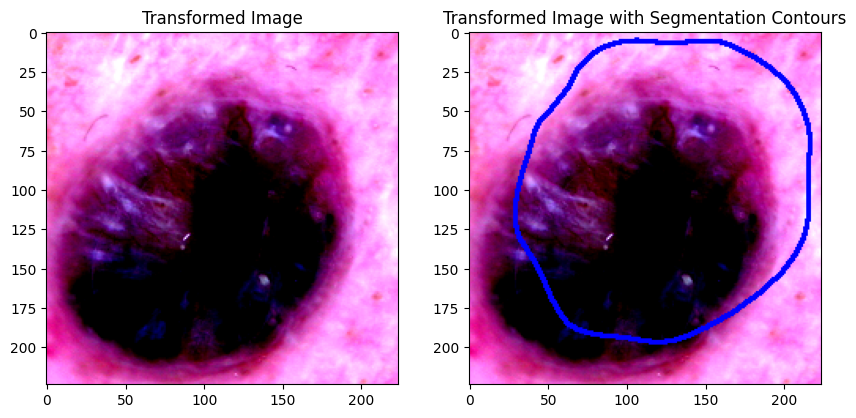

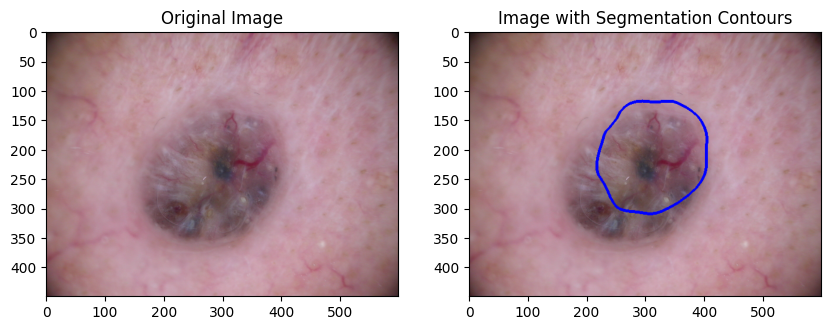

In [54]:
# 이미지 읽기
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 이미지 변환 적용
transformed = transforms(image=image)
transformed_image = transformed['image']

# 모델에 입력을 위한 배치 차원 추가
input_image = transformed_image.unsqueeze(0).to(device)

# 모델을 사용하여 예측
model.eval()
with torch.no_grad():
    output = model(input_image)

# 예측된 마스크 확인
output_mask = output.squeeze().cpu().numpy()
# 시그모이드 활성화 함수가 적용된 출력을 이진 마스크로 변환
binary_mask = (output_mask > 0.5).astype(np.uint8)

# 외곽선 찾기
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 노이즈 제거를 위해 작은 외곽선 제거
contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]  # 예: 면적이 100 이하인 외곽선 제거

# 변환된 이미지에 외곽선 그리기
transformed_image_np = transformed_image.permute(1, 2, 0).cpu().numpy()
transformed_image_with_contours = cv2.drawContours(transformed_image_np.copy(), contours, -1, (0, 0, 255), 2)

# 결과 출력
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Transformed Image')
plt.imshow(transformed_image_np)

plt.subplot(1, 2, 2)
plt.title('Transformed Image with Segmentation Contours')
plt.imshow(transformed_image_with_contours)
plt.show()

# 예측된 마스크 확인
output_mask = output.squeeze().cpu().numpy()
binary_mask = (output_mask > 0.5).astype(np.uint8)

# 마스크를 원본 이미지의 중앙으로 이동
mask_center_y, mask_center_x = binary_mask.shape[0] // 2, binary_mask.shape[1] // 2
image_center_y, image_center_x = image.shape[0] // 2, image.shape[1] // 2

# 원본 이미지 크기의 빈 마스크 생성
centered_mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)

# 중앙으로 이동한 좌표 계산
start_y = image_center_y - mask_center_y
start_x = image_center_x - mask_center_x

# 중앙으로 이동한 마스크 복사
centered_mask[start_y:start_y + binary_mask.shape[0], start_x:start_x + binary_mask.shape[1]] = binary_mask

# 외곽선 찾기
contours, _ = cv2.findContours(centered_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 노이즈 제거를 위해 작은 외곽선 제거
contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]  # 예: 면적이 100 이하인 외곽선 제거

# 원본 이미지에 외곽선 그리기
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0, 0, 255), 4)

# 결과 출력
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title('Image with Segmentation Contours')
plt.imshow(image_with_contours)
plt.show()



In [9]:
# 이미지 읽기
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

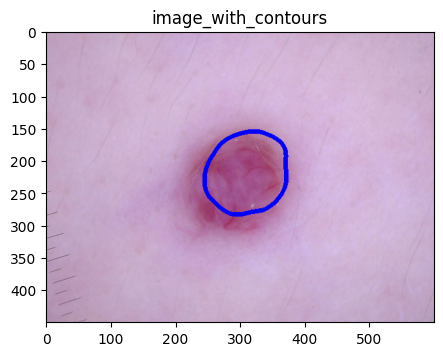

In [13]:
# 이미지 변환 적용
transformed = transforms(image=image)
transformed_image = transformed['image']

# 모델에 입력을 위한 배치 차원 추가
input_image = transformed_image.unsqueeze(0).to(device)

# 모델을 사용하여 예측
model.eval()
with torch.no_grad():
    output = model(input_image)

# 예측된 마스크 확인
output_mask = output.squeeze().cpu().numpy()
binary_mask = (output_mask > 0.6).astype(np.uint8)

# 마스크를 원본 이미지의 중앙으로 이동
mask_center_y, mask_center_x = binary_mask.shape[0] // 2, binary_mask.shape[1] // 2
image_center_y, image_center_x = image.shape[0] // 2, image.shape[1] // 2

# 원본 이미지 크기의 빈 마스크 생성
centered_mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)

# 중앙으로 이동한 좌표 계산
start_y = image_center_y - mask_center_y
start_x = image_center_x - mask_center_x

# 중앙으로 이동한 마스크 복사
centered_mask[start_y:start_y + binary_mask.shape[0], start_x:start_x + binary_mask.shape[1]] = binary_mask

# 외곽선 찾기
contours, _ = cv2.findContours(centered_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 노이즈 제거를 위해 작은 외곽선 제거
contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]  # 예: 면적이 100 이하인 외곽선 제거

# 원본 이미지에 외곽선 그리기
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0, 0, 255), 6)

# 결과 출력
plt.figure(figsize=(5, 5))
plt.title('image_with_contours')
plt.imshow(image_with_contours)
plt.show()


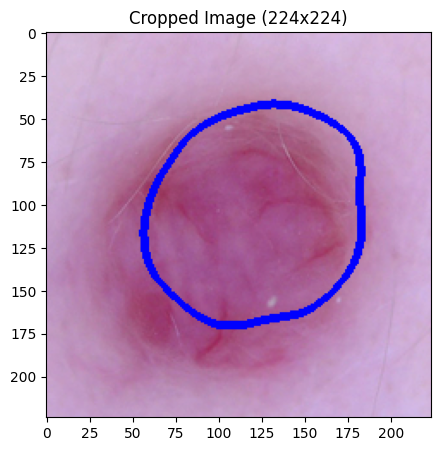

In [10]:
# 이미지 변환 적용
transformed = transforms(image=image)
transformed_image = transformed['image']

# 모델에 입력을 위한 배치 차원 추가
input_image = transformed_image.unsqueeze(0).to(device)

# 모델을 사용하여 예측
model.eval()
with torch.no_grad():
    output = model(input_image)

# 예측된 마스크 확인
output_mask = output.squeeze().cpu().numpy()
binary_mask = (output_mask > 0.5).astype(np.uint8)

# 마스크를 원본 이미지의 중앙으로 이동
mask_center_y, mask_center_x = binary_mask.shape[0] // 2, binary_mask.shape[1] // 2
image_center_y, image_center_x = image.shape[0] // 2, image.shape[1] // 2

# 원본 이미지 크기의 빈 마스크 생성
centered_mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)

# 중앙으로 이동한 좌표 계산
start_y = image_center_y - mask_center_y
start_x = image_center_x - mask_center_x

# 중앙으로 이동한 마스크 복사
centered_mask[start_y:start_y + binary_mask.shape[0], start_x:start_x + binary_mask.shape[1]] = binary_mask

# 외곽선 찾기
contours, _ = cv2.findContours(centered_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 노이즈 제거를 위해 작은 외곽선 제거
contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]  # 예: 면적이 100 이하인 외곽선 제거

# 원본 이미지에 외곽선 그리기
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0, 0, 255), 4)
# 마스크 처리된 이미지를 중앙 기준으로 224x224로 잘라서 출력

# 자를 이미지의 크기 설정
crop_size = 224

# 이미지와 마스크의 중심 좌표 계산
center_y, center_x = image_with_contours.shape[0] // 2, image_with_contours.shape[1] // 2

# 자를 이미지의 시작 좌표 계산
start_y = max(center_y - crop_size // 2, 0)
start_x = max(center_x - crop_size // 2, 0)

# 자를 이미지의 끝 좌표 계산
end_y = min(start_y + crop_size, image_with_contours.shape[0])
end_x = min(start_x + crop_size, image_with_contours.shape[1])

# 중앙을 기준으로 224x224 크기로 이미지 자르기
cropped_image = image_with_contours[start_y:end_y, start_x:end_x]

# 결과 출력
plt.figure(figsize=(5, 5))
plt.title('Cropped Image (224x224)')
plt.imshow(cropped_image)
plt.show()


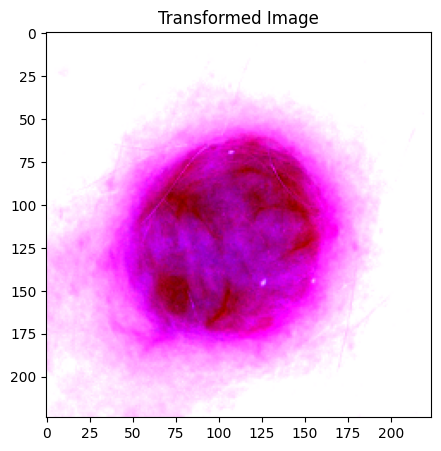

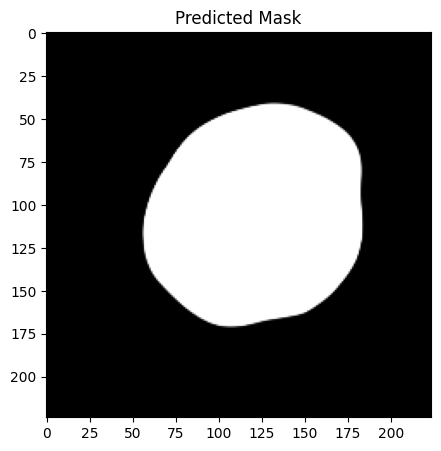

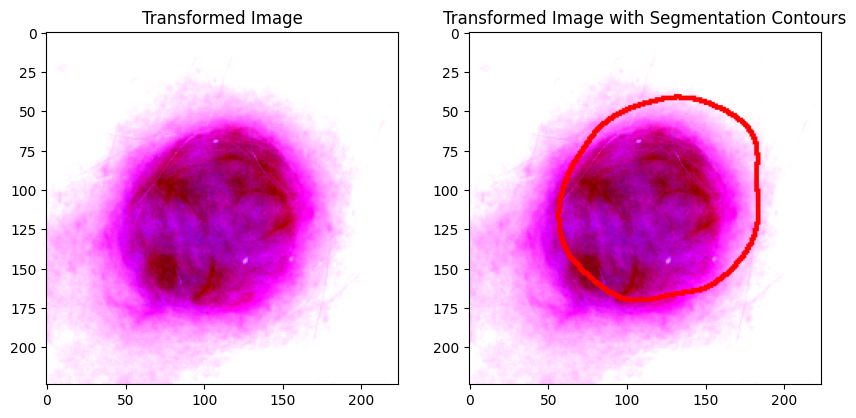

In [ ]:
import cv2
import numpy as np
import torch
from albumentations import Compose, CenterCrop, Resize, Normalize
from albumentations.pytorch import ToTensorV2
from segmentation_models_pytorch import Unet
import matplotlib.pyplot as plt

# 모델 설정
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['lesion']
ACTIVATION = 'sigmoid'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Unet(encoder_name=ENCODER,
             encoder_weights=ENCODER_WEIGHTS,
             classes=len(CLASSES),
             activation=ACTIVATION)
model = model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/model/best_model.pth'))

# 데이터 변환
transforms = Compose([
    CenterCrop(300, 300),
    Resize(224, 224),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], additional_targets={'mask': 'mask'}, is_check_shapes=False)

# 이미지 읽기
image_path = '/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/dataset/images/ISIC_0025599.jpg'  # 업로드한 이미지 경로로 변경
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 이미지 변환 적용
transformed = transforms(image=image)
transformed_image = transformed['image']

# 변환된 이미지 확인
plt.figure(figsize=(5, 5))
plt.title('Transformed Image')
plt.imshow(transformed_image.permute(1, 2, 0).cpu().numpy())
plt.show()

# 모델에 입력을 위한 배치 차원 추가
input_image = transformed_image.unsqueeze(0).to(device)

# 모델을 사용하여 예측
model.eval()
with torch.no_grad():
    output = model(input_image)

# 예측된 마스크 확인
output_mask = output.squeeze().cpu().numpy()
plt.figure(figsize=(5, 5))
plt.title('Predicted Mask')
plt.imshow(output_mask, cmap='gray')
plt.show()

# 시그모이드 활성화 함수가 적용된 출력을 이진 마스크로 변환
binary_mask = (output_mask > 0.5).astype(np.uint8)

# 외곽선 찾기
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 노이즈 제거를 위해 작은 외곽선 제거
contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]  # 예: 면적이 100 이하인 외곽선 제거

# 변환된 이미지에 외곽선 그리기
transformed_image_np = transformed_image.permute(1, 2, 0).cpu().numpy()
transformed_image_with_contours = cv2.drawContours(transformed_image_np.copy(), contours, -1, (255, 0, 0), 2)

# 결과 출력
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Transformed Image')
plt.imshow(transformed_image_np)

plt.subplot(1, 2, 2)
plt.title('Transformed Image with Segmentation Contours')
plt.imshow(transformed_image_with_contours)
plt.show()
